In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.preprocessing     # For StandardScaler
import sklearn.linear_model      # For LogisticRegression
import sklearn.neural_network    # For MLPClassifier
import torch
import warnings
import os
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)  # Annoying
np.set_printoptions(precision=3, suppress=True)  # Print as 0.001 instead of 9.876e-4

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd ..

%cd /content/drive/MyDrive/Dataset 2/Prostate Cancer
import shutil
import os

# Set the source folder and destination folder paths
source_folder2 = '/content/drive/MyDrive/Dataset 2/Prostate Cancer'
# path to your dataset
destination_folder2 = '/content/Dataset 2'

# Remove the existing folder if it exists
if os.path.exists(destination_folder2):
    shutil.rmtree(destination_folder2)

# Copy the dataset to the destination folder
shutil.copytree(source_folder2, destination_folder2)


%cd /content/Dataset 2


# List files in the destination folder
os.listdir(destination_folder2)




/
/content/drive/MyDrive/Dataset 2/Prostate Cancer
/content/Dataset 2


['gland', 'tumor', 'nongland']

In [ ]:
# Check the number of .tif files and missing data
expected_count = 6000  # Replace with the expected count

# List all .jpg files in the dataset directory
all_jpg_files = []
for root, dirs, files in os.walk(destination_folder2):
    jpg_files = [file for file in files if file.endswith('.jpg')]
    all_jpg_files.extend(jpg_files)

unique_jpg_files = list(set(all_jpg_files))
print(f"Total .jpg images found: {len(unique_jpg_files)}")

# Remove jpg duplicates in Dataset 1
filtered_jpg_files = [file for file in unique_jpg_files if "(1)" not in file and "(2)" not in file]


# Calculate the total count of .tif files after removing duplicates
total_count = len(filtered_jpg_files)


# Print the results
print(f"Total unique .jpg images found: {total_count}")
print(f"Expected count: {expected_count}")
print(f"Missing data: {expected_count - total_count} files are missing.")

Total .jpg images found: 6003
Total unique .jpg images found: 6000
Expected count: 6000
Missing data: 0 files are missing.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms

# List all image files in the dataset directory
image_paths = []
for root, dirs, files in os.walk(destination_folder2):
    for file in files:
        image_paths.append(os.path.join(root, file))


In [ ]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot
from matplotlib import image
import time

def load_data(path, test_split,batch_size,input_size):
   transform_dict = {
      'scr': transforms.Compose(
      [ transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      ])}
   data = datasets.ImageFolder(root=path, transform=transform_dict['scr'])

   dataset_size = len(data)
   test_size = int(dataset_size * test_split)
   train_size = dataset_size - test_size

   train_dataset, test_dataset = td.random_split(data, [train_size, test_size])
   train_loader = td.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=0)
   test_loader = td.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0)
   data_loader = td.DataLoader(data, batch_size=batch_size, shuffle=True)
   return train_loader, test_loader, data

In [ ]:
path = destination_folder2
test_split = 0.0
batch_size = 100
input_size = (224, 224)


train_loader2, test_loader2, data_loader2 = load_data(path, test_split, batch_size, input_size)

print(len(train_loader2))
print(len(test_loader2))
print(len(data_loader2))

61
0
6003


Batch Shape: torch.Size([100, 3, 224, 224])


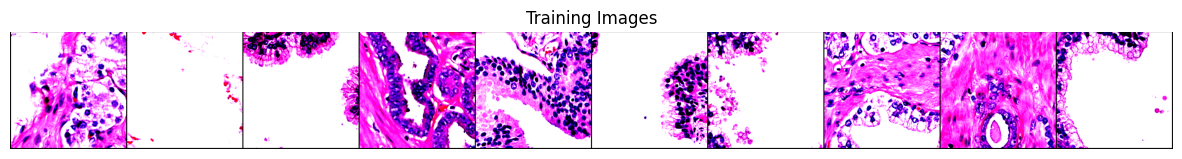

In [ ]:
import matplotlib.pyplot as plt
import torchvision

# Function to display a subset of images in a grid
def show_images(images, title, num_images=10):

    grid = torchvision.utils.make_grid(images[:num_images], nrow=num_images)

    grid = grid.permute(1, 2, 0)
    grid = grid.numpy()
    plt.figure(figsize=(15, 15))
    plt.imshow(grid)
    plt.title(title)
    plt.axis('off')
    plt.show()


# Iterate through one batch from the train_loader
for inputs, labels in train_loader2:
    print(f"Batch Shape: {inputs.shape}")
    show_images(inputs, 'Training Images', num_images=10)
    break


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models  # Add this import statement
from sklearn.manifold import TSNE
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 3
print(device)


# Print the number of samples in training and testing sets

num_batches = len(train_loader2)
print(f"Number of batches in train_loader: {num_batches}")

total_train_samples = num_batches * batch_size
print(f"Total number of samples in the training set: {total_train_samples}")

num_test_batches = len(test_loader2)
print(f"Number of batches in train_loader: {num_test_batches}")

total_test_samples = num_test_batches * batch_size
print(f"Total number of samples in the testing set: {total_test_samples}")

cuda
Number of batches in train_loader: 61
Total number of samples in the training set: 6100
Number of batches in train_loader: 0
Total number of samples in the testing set: 0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 97.1MB/s]


Embedded Features Shape: (6003, 2)


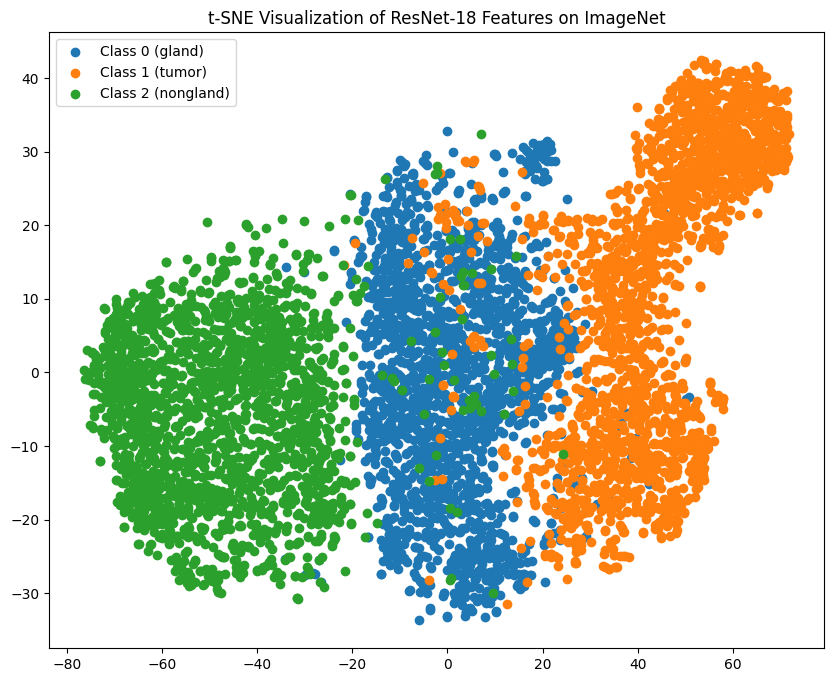

In [ ]:
import torch
from torchvision import models, transforms
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

class_labels = {0: 'gland', 1: 'tumor', 2: 'nongland'}

num_classes = len(class_labels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)
model.to(device)
model.eval()

# Remove the final fully connected layer and the classification layer
model = nn.Sequential(*list(model.children())[:-1])

# Define transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create a dataset from the ImageNet folder
imagenet_dataset = ImageFolder(root=destination_folder2, transform=transform)

# Use a DataLoader to iterate over the dataset
batch_size = 32
dataloader = DataLoader(imagenet_dataset, batch_size=batch_size, shuffle=True)

# Feature extraction loop
feature_vectors = []
true_labels = []

with torch.no_grad():
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)

        # Flatten the features before appending to feature_vectors
        features_flat = outputs.view(outputs.size(0), -1).cpu().numpy()
        feature_vectors.append(features_flat)
        true_labels.append(labels.cpu().numpy())

# Concatenate the features from all batches
feature_vectors = np.concatenate(feature_vectors, axis=0)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(feature_vectors)

print("Embedded Features Shape:", embedded_features.shape)

flat_true_labels = np.concatenate(true_labels)

# Check for any NaN or infinite values in the embedded features
if np.isnan(embedded_features).any() or np.isinf(embedded_features).any():
    print("NaN or infinite values found in embedded features.")

# Plot the t-SNE embeddings
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    indices = flat_true_labels == i
    plt.scatter(embedded_features[indices, 0], embedded_features[indices, 1], label=f'Class {i} ({class_labels[i]})')

plt.title('t-SNE Visualization of ResNet-18 Features on ImageNet')
plt.legend()
plt.show()
